<Item title:"Pittsburgh heart attacks" type:Feature Layer Collection owner:api_data_owner>
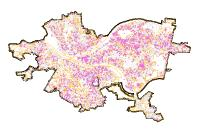

In [24]:
from arcgis.gis import GIS
from arcgis.mapping import WebMap
from arcgis.widgets import MapView
from arcgis.features import FeatureCollection, use_proximity
from datetime import datetime

gis = GIS(url='https://pythonapi.playground.esri.com/portal', username='arcgis_python', password='amazing_arcgis_123')
ohca_item = gis.content.get('a5719916dff4442789a59680c25a4284')
ohca_item

In [25]:
for lyr in ohca_item.layers:
    print(lyr.properties.name)

Heart attack incidence
Streets
Zoning
Boundary


In [26]:
# convert to a geopandas dataframe
import pandas as pd
import geopandas as gpd
from arcgis.features import GeoAccessor, GeoSeriesAccessor

ohca_df = pd.DataFrame.spatial.from_layer(ohca_item.layers[0])
ohca_df.head()

,SHAPE,fid_1,id,no,num_incidence,objectid_1,pop2000,yes
0,"{""x"": -79.97274830899988, ""y"": 40.437756305000...",0,1,1,0,1,0,0
1,"{""x"": -79.97639852099996, ""y"": 40.437202953000...",8,9,1,0,2,96,0
2,"{""x"": -79.98023401899997, ""y"": 40.438334899000...",12,13,1,0,3,5,0
3,"{""x"": -79.9818761219999, ""y"": 40.4383995900001...",13,14,1,0,4,3,0
4,"{""x"": -79.98428402499985, ""y"": 40.437456611000...",25,26,1,0,5,15,0


In [27]:
# create x and y columns for folium
ohca_df['x'] = ohca_df['SHAPE'].apply(lambda p: p['x'])
ohca_df['y'] = ohca_df['SHAPE'].apply(lambda p: p['y'])
ohca_df.head()

,SHAPE,fid_1,id,no,num_incidence,objectid_1,pop2000,yes,x,y
0,"{""x"": -79.97274830899988, ""y"": 40.437756305000...",0,1,1,0,1,0,0,-79.972748,40.437756
1,"{""x"": -79.97639852099996, ""y"": 40.437202953000...",8,9,1,0,2,96,0,-79.976399,40.437203
2,"{""x"": -79.98023401899997, ""y"": 40.438334899000...",12,13,1,0,3,5,0,-79.980234,40.438335
3,"{""x"": -79.9818761219999, ""y"": 40.4383995900001...",13,14,1,0,4,3,0,-79.981876,40.438400
4,"{""x"": -79.98428402499985, ""y"": 40.437456611000...",25,26,1,0,5,15,0,-79.984284,40.437457


In [28]:
# plot data on a map
import folium
from folium.plugins import HeatMap

zoom_start = 13

# make a heatmap
m = folium.Map(location=[40.4406, -79.9959], zoom_start=zoom_start)
HeatMap(data=ohca_df[['y', 'x']], radius=15).add_to(m)
m

In [29]:
# download church coordinates
import overpass
from pyproj import CRS

def download_church_coordinates(city, state):
    # Define the query to retrieve churches in the specified city and state
    query = """
        area["name"="Pittsburgh"];
        node["amenity"="place_of_worship"](area);
        out;
    """

    # Set up the Overpass API
    api = overpass.API()

    # Make the query and get the results
    response = api.Get(query, responseformat="geojson")

    # # Extract and print the coordinates of each church
    # for feature in response['features']:
    #     coordinates = feature['geometry']['coordinates']
    #     print(f"Church: {feature['properties']['name']} - Coordinates: {coordinates}")
    return response

corrds = download_church_coordinates('Pittsburgh', 'Pennsylvania')

# calculate the increse in OHCA incidents within 100 meters of each church using geopandas
churches = gpd.GeoDataFrame.from_features(corrds)
# set epsg to 4326
churches.crs = CRS.from_epsg(4326)
churches.head()

,geometry,amenity,ele,gnis:county_id,gnis:created,gnis:feature_id,gnis:state_id,name,religion,denomination,...,wheelchair,gnis:county_name,gnis:reviewed,place_of_worship,source,building,gnis:import_uuid,wikipedia,note,toilets:wheelchair
0,POINT (-79.97420 40.42569),place_of_worship,231,003,08/30/1990,1196451,42,Saint Casimir Church,christian,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (-79.95283 40.43563),place_of_worship,281,003,08/30/1990,1196503,42,Saint George Orthodox Church,christian,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (-79.95616 40.44868),place_of_worship,304,003,08/30/1990,1196555,42,First Baptist Church,christian,baptist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (-79.89644 40.45674),place_of_worship,280,003,08/30/1990,1196565,42,First Methodist Church,christian,methodist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-79.96417 40.44000),place_of_worship,314,003,12/29/2006,2103433,42,Mother of Mercy Chapel,christian,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# calculate the increase in OHCA incidents within 100 meters of each church
from scipy.spatial import KDTree

# convert to epsg2272
# create geodataframe
ohca = gpd.GeoDataFrame(ohca_df, geometry=gpd.points_from_xy(ohca_df.x, ohca_df.y))
ohca.crs = CRS.from_epsg(4326)
ohca = ohca.to_crs(epsg=2272)
churches = churches.to_crs(epsg=2272)

# add columns x and y to frames with epsg2272
ohca['x'] = ohca['geometry'].apply(lambda p: p.x)
ohca['y'] = ohca['geometry'].apply(lambda p: p.y)
churches['x'] = churches['geometry'].apply(lambda p: p.x)
churches['y'] = churches['geometry'].apply(lambda p: p.y)

# convert back to epsg4326
ohca = ohca.to_crs(epsg=4326)
churches = churches.to_crs(epsg=4326)

# create a KDTree from ohcas
ohca_kdtree = KDTree(ohca[['x', 'y']].values)

church_incidents = {} # (lat, lon) -> [(lat, lon), ...]

dist = 200

for i, church in churches.iterrows():
    # find all ohcas within 100 meters of the church
    ohcas = ohca_kdtree.query_ball_point([church.x, church.y], r=dist)
    # convert to lat, lon
    ohcas = ohca.iloc[ohcas].geometry.apply(lambda p: (p.y, p.x)).values.tolist()
    # add to dict with epsg4326
    if len(ohcas) > 0:
        church_incidents[(church.geometry.y, church.geometry.x)] = ohcas


In [34]:
# draw a map of the churches and the number of OHCA incidents near each church
m = folium.Map(location=[40.4406, -79.9959], zoom_start=zoom_start)
for church, incidents in church_incidents.items():
    folium.Marker(location=church, popup=f"{len(incidents)} incidents").add_to(m)
    # red marker
    for incident in incidents:
        folium.CircleMarker(location=incident, radius=2, color='red').add_to(m)
m

In [35]:
print(f"Out of {len(churches)} churches, {len(church_incidents)} had at least one OHCA incident within {dist} meters.")
inc_sum = sum([len(incidents) for incidents in church_incidents.values()])
print(f"There were {inc_sum} incidents within {dist} meters of a church out of {len(ohca)} total incidents.")

Out of 314 churches, 28 had at least one OHCA incident within 200 meters.
There were 36 incidents within 200 meters of a church out of 1536 total incidents.
